In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import patches
import seaborn as sns
sns.set_theme()
import pandas as pd
import mne
from scipy.fftpack import fft
from numpy.fft import rfft, irfft, rfftfreq
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
import tensorflow as tf
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
from meegkit import dss, ress
from meegkit import sns as msns
from meegkit.utils import unfold, rms, fold, tscov, matmul3d, snr_spectrum
from brainda.paradigms import SSVEP
from brainda.algorithms.utils.model_selection import (
    set_random_seeds, 
    generate_loo_indices, match_loo_indices)
from brainda.algorithms.decomposition import (
    FBTRCA, FBTDCA, FBSCCA, FBECCA, FBDSP,
    generate_filterbank, generate_cca_references)
from collections import OrderedDict
import numpy as np
from scipy.signal import sosfiltfilt
from sklearn.pipeline import clone
from sklearn.metrics import balanced_accuracy_score

c:\Users\simon\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
def load_data_temp_function(eeg, meta, classes, stim_duration=5, filter=True):
    trials = meta[1:,:2]
    times = []
    for index, row in eeg.loc[eeg[' TRG']==1].iterrows():
        if eeg.iloc[index-1][' TRG'] == 0:
            # print(row['time'])
            times.append(row['time'])
    times = np.array(times)
    duration_samples = int(stim_duration*300)
    # eeg['time'] = eeg['time'] - eeg['time'].iloc[0]
    # eeg = np.array([eeg.loc[eeg['time']>t].drop(columns=['time',' TRG']).to_numpy()[:1725].T for t in times])[:,:,225:]
    # eeg = np.array([eeg.loc[eeg['time']>t].drop(columns=['time']).to_numpy()[:1725].T for t in times])[:,:,225:]
    eeg = np.array([eeg.loc[eeg['time']>t].drop(columns=['time',' TRG']).to_numpy()[:duration_samples].T for t in times])
    if filter:
        eeg = mne.filter.filter_data(eeg, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir')
    # eeg = mne.filter.filter_data(eeg, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir',phase='minimum')
    eeg_temp = []
    for i in range(len(classes)):
        eeg_temp.append([])
    for i,freq in enumerate(trials):
        for j,target in enumerate(classes):
            if (freq==target).all():
                eeg_temp[j].append(eeg[i])
    eeg = np.array(eeg_temp).transpose(1,0,2,3)
    return eeg

In [101]:
sub_dirs = ['8hz/','9hz/','10hz/','11hz/','12hz/','13hz/','14hz/','15hz/']
duration = 5

# load experimental dataset
eeg_whole = np.zeros((5,32,7,1500))
target_tab = {}
i_class = 0
for i_dir,sub_dir in enumerate(sub_dirs):

    data_path = "../data/eeg_recordings/pilot_data/simon/ws32_6/" + sub_dir
    eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
    meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
    trials = meta[1:,:2]
    classes = np.unique(trials, axis=0)
    more_targets = {tuple(target):index+i_class for index,target in enumerate(classes)}
    target_tab.update(more_targets)
    eeg = load_data_temp_function(eeg, meta, classes, stim_duration=duration,filter=False)
    eeg_whole[:,i_class:(i_class+4),:,:] = eeg
    i_class+=4
eeg1 = eeg_whole
target_by_trial = [list(target_tab.keys())] * 5
eeg1.shape, np.array(target_by_trial).shape 

((5, 32, 7, 1500), (5, 32, 2))

In [102]:
sub_dirs = ['8hz/','9hz/','10hz/','11hz/','12hz/','13hz/','14hz/','15hz/']
duration = 5

# load experimental dataset
eeg_whole = np.zeros((5,32,7,1500))
target_tab = {}
i_class = 0
for i_dir,sub_dir in enumerate(sub_dirs):

    data_path = "../data/eeg_recordings/pilot_data/simon/ws32_7/" + sub_dir
    eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
    meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
    trials = meta[1:,:2]
    classes = np.unique(trials, axis=0)
    more_targets = {tuple(target):index+i_class for index,target in enumerate(classes)}
    target_tab.update(more_targets)
    eeg = load_data_temp_function(eeg, meta, classes, stim_duration=duration,filter=False)
    eeg_whole[:,i_class:(i_class+4),:,:] = eeg
    i_class+=4
eeg2 = eeg_whole
target_by_trial = [list(target_tab.keys())] * 10
eeg2.shape, np.array(target_by_trial).shape 

((5, 32, 7, 1500), (10, 32, 2))

In [103]:
eeg3 = np.vstack((eeg1,eeg2))
eeg3.shape

(10, 32, 7, 1500)

In [104]:
sub_dirs = ['8hz/','9hz/','10hz/','11hz/','12hz/','13hz/','14hz/','15hz/']
duration = 1
n_trials = 10
n_classes = 32

# load experimental dataset
eeg_whole = np.zeros((n_trials,n_classes,7,int(duration*300)))
target_tab = {}
i_class = 0
for i_dir,sub_dir in enumerate(sub_dirs):

    data_path = "../data/eeg_recordings/pilot_data/simon/ws32_8/" + sub_dir
    eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
    meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
    trials = meta[1:,:2]
    classes = np.unique(trials, axis=0)
    more_targets = {tuple(target):index+i_class for index,target in enumerate(classes)}
    target_tab.update(more_targets)
    eeg = load_data_temp_function(eeg, meta, classes, stim_duration=duration,filter=False)
    eeg_whole[:,i_class:(i_class+4),:,:] = eeg
    i_class+=4
eeg4 = eeg_whole
target_by_trial = [list(target_tab.keys())] * 20
eeg4.shape, np.array(target_by_trial).shape 

((10, 32, 7, 300), (20, 32, 2))

In [105]:
eeg5 = np.vstack((eeg3[:,:,:,:300],eeg4))
eeg5.shape

(20, 32, 7, 300)

In [106]:
sub_dirs = ['8hz/','9hz/','10hz/','11hz/','12hz/','13hz/','14hz/','15hz/']
duration = 1
n_trials = 20
n_classes = 32

# load experimental dataset
eeg_whole = np.zeros((n_trials,n_classes,7,int(duration*300)))
target_tab = {}
i_class = 0
for i_dir,sub_dir in enumerate(sub_dirs):

    data_path = "../data/eeg_recordings/pilot_data/simon/ws32_9/" + sub_dir
    eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
    meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
    trials = meta[1:,:2]
    classes = np.unique(trials, axis=0)
    more_targets = {tuple(target):index+i_class for index,target in enumerate(classes)}
    target_tab.update(more_targets)
    eeg = load_data_temp_function(eeg, meta, classes, stim_duration=duration,filter=False)
    eeg_whole[:,i_class:(i_class+4),:,:] = eeg
    i_class+=4
eeg6 = eeg_whole
target_by_trial = [list(target_tab.keys())] * 40
eeg6.shape, np.array(target_by_trial).shape 

((20, 32, 7, 300), (40, 32, 2))

In [107]:
eeg7 = np.vstack((eeg5,eeg6))
eeg7.shape

(40, 32, 7, 300)

In [108]:
sub_dirs = ['8hz/','9hz/','10hz/','11hz/','12hz/','13hz/','14hz/','15hz/']
duration = 1
n_trials = 20
n_classes = 32

# load experimental dataset
eeg_whole = np.zeros((n_trials,n_classes,7,int(duration*300)))
target_tab = {}
i_class = 0
for i_dir,sub_dir in enumerate(sub_dirs):

    data_path = "../data/eeg_recordings/pilot_data/simon/ws32_10/" + sub_dir
    eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
    meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
    trials = meta[1:,:2]
    classes = np.unique(trials, axis=0)
    more_targets = {tuple(target):index+i_class for index,target in enumerate(classes)}
    target_tab.update(more_targets)
    eeg = load_data_temp_function(eeg, meta, classes, stim_duration=duration,filter=False)
    eeg_whole[:,i_class:(i_class+4),:,:] = eeg
    i_class+=4
eeg8 = eeg_whole
target_by_trial = [list(target_tab.keys())] * 60
eeg8.shape, np.array(target_by_trial).shape 

((20, 32, 7, 300), (60, 32, 2))

In [109]:
eeg = np.vstack((eeg7,eeg8))
eeg.shape

(60, 32, 7, 300)

In [115]:
n_trials = 50
# classes = [0,7,15,23,31]
classes = range(32)
n_classes = len(classes)
y = np.array([list(target_tab.values())] * n_trials).T.reshape(-1)
eeg_temp = eeg[:n_trials,classes,:,40:]
# X = eeg.swapaxes(0,1).reshape(-1,*eeg.shape[2:])
X = eeg_temp.swapaxes(0,1).reshape(-1,*eeg_temp.shape[2:])


freq_targets = np.array(target_by_trial)[0,:,0]
phase_targets = np.array(target_by_trial)[0,:,1]
n_harmonics = 5
n_bands = 3
srate = 300
duration = 0.7
Yf = generate_cca_references(
    freq_targets, srate, duration, 
    phases=phase_targets, 
    n_harmonics=n_harmonics)
wp = [[8*i, 90] for i in range(1, n_bands+1)]
ws = [[8*i-2, 95] for i in range(1, n_bands+1)]
filterbank = generate_filterbank(
    wp, ws, srate, order=4, rp=1)
filterweights = np.arange(1, len(filterbank)+1)**(-1.25) + 0.25
set_random_seeds(64)
l = 5
models = OrderedDict([
    # ('fbscca', FBSCCA(
    #         filterbank, filterweights=filterweights)),
    # ('fbecca', FBECCA(
    #         filterbank, filterweights=filterweights)),
    ('fbdsp', FBDSP(
            filterbank, filterweights=filterweights)),
    ('fbtrca', FBTRCA(
            filterbank, filterweights=filterweights)),
    ('fbtdca', FBTDCA(
            filterbank, l, n_components=8, 
            filterweights=filterweights)),
])
events = []
# for j_class in range(32):
for j_class in classes:
    events.extend([str(target_by_trial[i_trial][j_class]) for i_trial in range(n_trials)])
events = np.array(events)
subjects = ['1'] * (n_classes*n_trials)
meta = pd.DataFrame(data=np.array([subjects,events]).T, columns=["subject", "event"])
set_random_seeds(42)
loo_indices = generate_loo_indices(meta)

for model_name in models:
    if model_name == 'fbtdca':
        filterX, filterY = np.copy(X[..., :int(srate*duration)+l]), np.copy(y)
    else:
        filterX, filterY = np.copy(X[..., :int(srate*duration)]), np.copy(y)
    
    filterX = filterX - np.mean(filterX, axis=-1, keepdims=True)

    n_loo = len(loo_indices['1'][events[0]])
    loo_accs = []
    for k in range(n_loo):
        train_ind, validate_ind, test_ind = match_loo_indices(
            k, meta, loo_indices)
        train_ind = np.concatenate([train_ind, validate_ind])

        trainX, trainY = filterX[train_ind], filterY[train_ind]
        testX, testY = filterX[test_ind], filterY[test_ind]

        model = clone(models[model_name]).fit(
            trainX, trainY,
            Yf=Yf
        )
        pred_labels = model.predict(testX)
        loo_accs.append(
            balanced_accuracy_score(testY, pred_labels))
    print("Model:{} LOO Acc:{:.2f}".format(model_name, np.mean(loo_accs)))

Model:fbdsp LOO Acc:0.45
Model:fbtrca LOO Acc:0.50
Model:fbtdca LOO Acc:0.63


In [112]:
y_pred = model.predict(eeg[59,:,:,40:280])
y_pred

array([ 0, 11,  2,  3, 26, 16,  4, 17, 17,  9, 10, 10, 12, 13,  3,  3, 16,
       21, 18, 13, 20, 21, 22, 23, 27, 22, 29, 27, 20,  1, 30, 23])

In [91]:
y_true = np.array(list(range(32))*40)

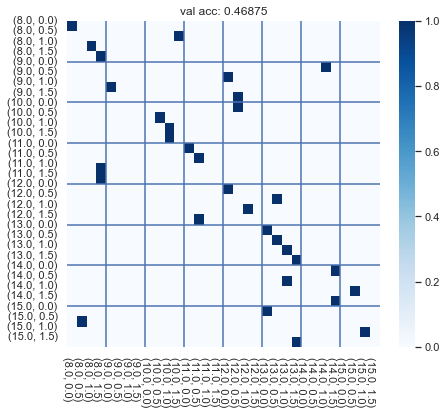

In [113]:
# confusion_matrix(y_pred,range(32))
plt.figure(figsize=(7, 6))
ax = sns.heatmap(confusion_matrix(range(32), y_pred,normalize='true'), cmap='Blues')
ax.set_title('val acc: '+str(accuracy_score(range(32), y_pred)));
ax.set_xticks(range(32))
ax.set_yticks(range(32))
ax.xaxis.set_ticklabels([str(e) for e in list(target_tab.keys())],rotation = -90);
ax.yaxis.set_ticklabels([str(e) for e in list(target_tab.keys())],rotation = 0);
ax.hlines([4,8,12,16,20,24,28], *ax.get_xlim())
ax.vlines([4,8,12,16,20,24,28], *ax.get_xlim())
plt.show()